# Group 14 - Project FP01
## Time series anomaly detection - LSTM-ED

This project aims at investigating the current state-of-the-arts TAD scenario.

In [20]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [1]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

2024-07-21 20:24:36.430320: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 20:24:36.736213: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 20:24:36.736273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 20:24:36.737614: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 20:24:36.896082: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [3]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [4]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 107.08723640441895 seconds ---


In [6]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (164, 2200)
y_test shape: (164,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (164, 96)
y_test shape: (164,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (141, 2200)
y_test shape: (141,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (141, 96)
y_test shape: (141,)



## LSTM-ED

In [7]:
from algorithms.lstm_enc_dec_axl import LSTMED

classifier = LSTMED(
    name='LSTM-ED',
    num_epochs=100,
    batch_size=32,
    lr=1e-4,
    hidden_size=64,
    sequence_length=100,
    train_gaussian_percentage=0.25,
    n_layers=(2, 2),
    use_bias=(True, True),
    dropout=(0.1, 0.1),
    seed=42,
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True
)
# Train the LSTM on normal data
classifier.fit(X_train)
print("LSTM-ED training completed.")


100%|██████████| 100/100 [06:21<00:00,  3.82s/it]


LSTM-ED training completed.


### Anomaly Detection

Anomaly prediction completed.


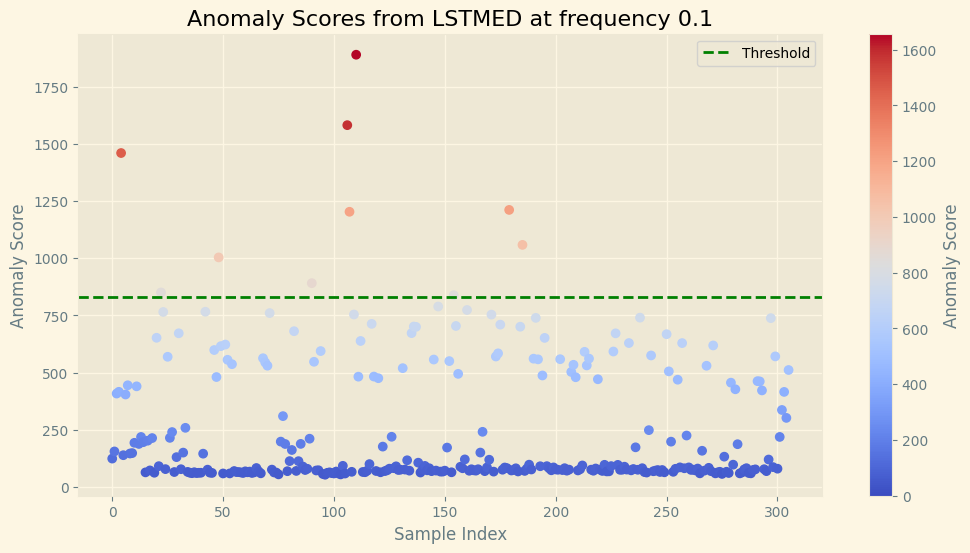

Number of anomalies detected: 10
Anomaly prediction completed.


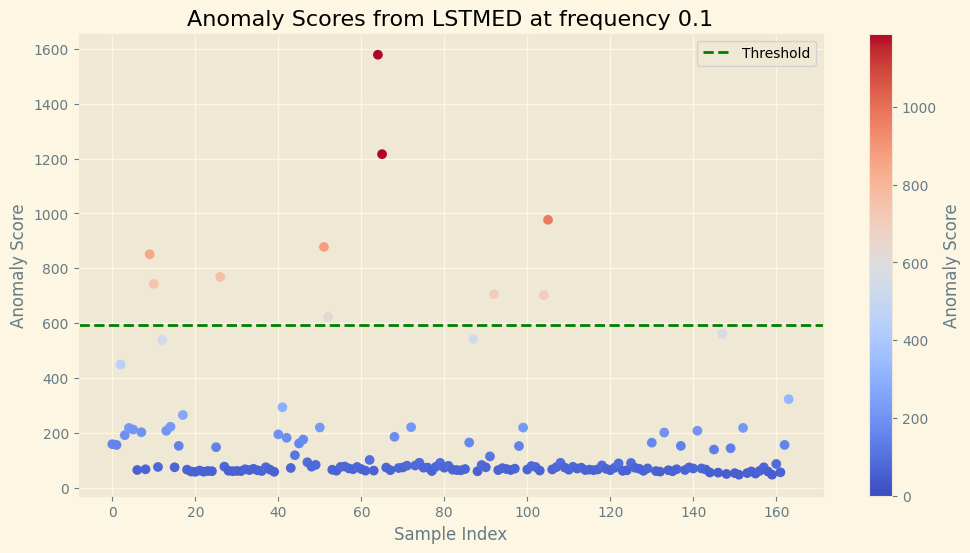

Number of anomalies detected: 10
Anomaly prediction completed.


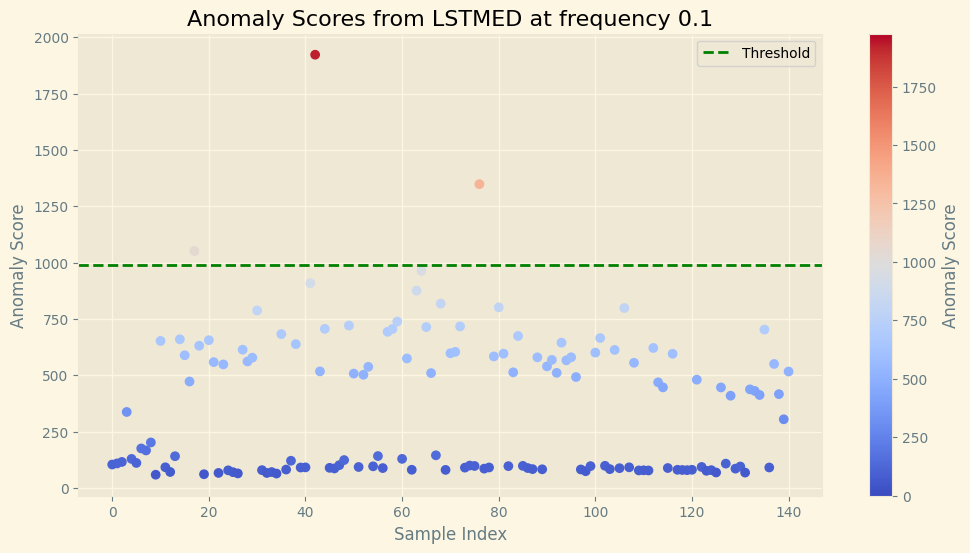

Number of anomalies detected: 3


In [8]:
anomaly_scores, anomalies_detected = plot_anomalies(classifier, X_test, y_test, freq)
anomaly_scores1, anomalies_detected1 = plot_anomalies(classifier, X_test1, y_test1, freq)
anomaly_scores5, anomalies_detected5 = plot_anomalies(classifier, X_test5, y_test5, freq)

In [9]:
anomaly_scores, y_test_binary = compute_metrics(classifier, X_test, y_test)
anomaly_scores1, y_test_binary1 = compute_metrics(classifier, X_test1, y_test1)
anomaly_scores5, y_test_binary5 = compute_metrics(classifier, X_test5, y_test5)

Anomaly scores statistics:
Mean: 254.2062770434234
Std: 287.1740224149491
Min: 53.903600123975544
Max: 1889.3733303286347
ROC AUC Score: 0.6988
Detected anomaly class: 2
Threshold: 828.5543
F1 Score: 0.1053
Accuracy: 0.9444
Precision: 0.1000
Recall: 0.1111
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       297
           1       0.10      0.11      0.11         9

    accuracy                           0.94       306
   macro avg       0.54      0.54      0.54       306
weighted avg       0.95      0.94      0.95       306

Anomaly scores statistics:
Mean: 154.45556616369592
Std: 219.87561810240274
Min: 46.99404086521084
Max: 1578.928178471175
ROC AUC Score: 0.8755
Detected anomaly class: 2
Threshold: 594.2068
F1 Score: 0.2500
Accuracy: 0.9268
Precision: 0.2000
Recall: 0.3333
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       158
           1       0.20      0.33      0.25       

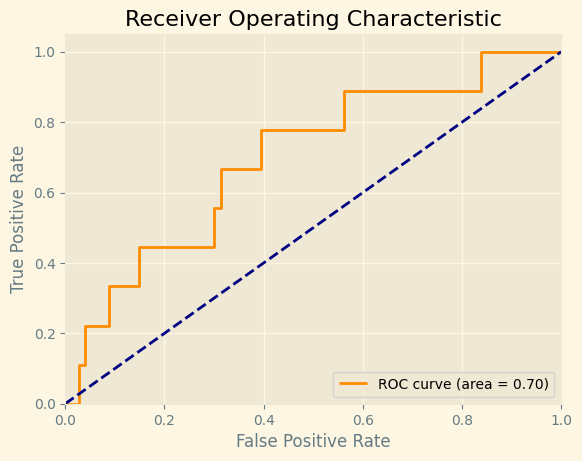

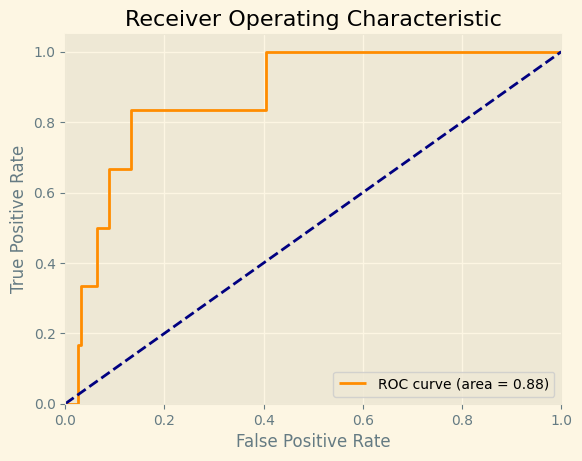

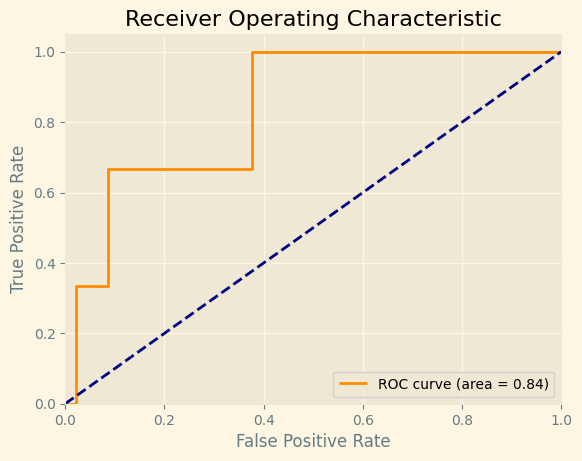

In [10]:
plot_roc_curve(y_test_binary, anomaly_scores)
plot_roc_curve(y_test_binary1, anomaly_scores1)
plot_roc_curve(y_test_binary5, anomaly_scores5)

## Map anomalies to original time series

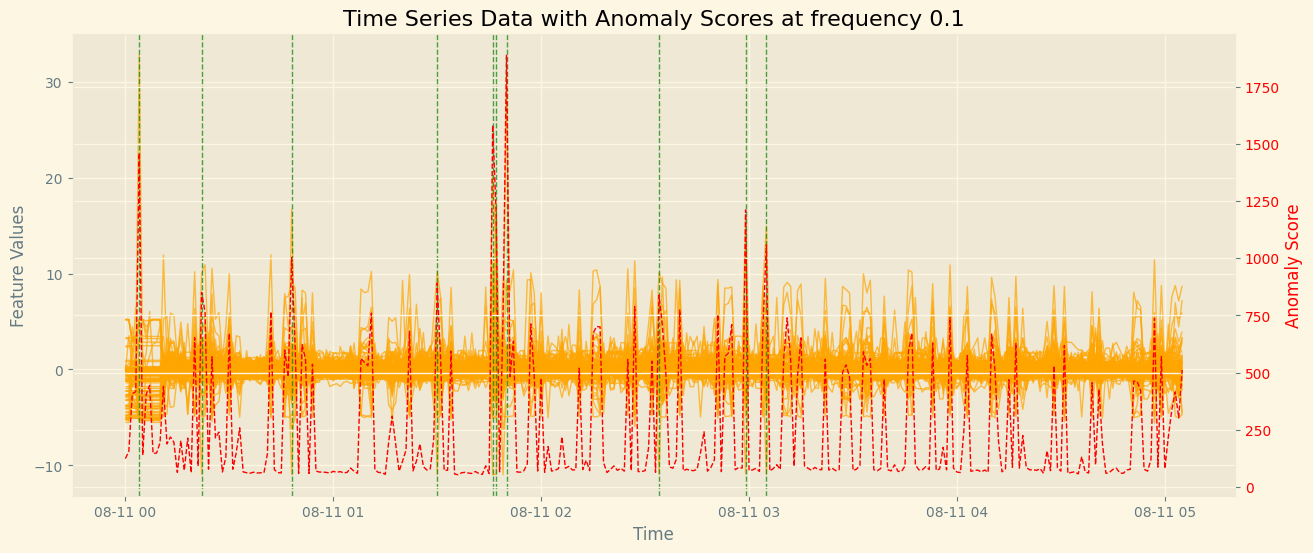

Top 10 Anomalies:
              timestamp  anomaly_score  \
110 2022-08-11 01:50:00    1889.373330   
106 2022-08-11 01:46:00    1581.560175   
4   2022-08-11 00:04:00    1459.769486   
179 2022-08-11 02:59:00    1211.167134   
107 2022-08-11 01:47:00    1203.037933   
185 2022-08-11 03:05:00    1058.364468   
48  2022-08-11 00:48:00    1003.620543   
90  2022-08-11 01:30:00     891.097812   
22  2022-08-11 00:22:00     850.471054   
154 2022-08-11 02:34:00     838.573103   

     machine_nameKuka Robot_apparent_power-_Average power  \
110                                          -0.911260      
106                                          -1.885449      
4                                            -5.323114      
179                                          -1.338344      
107                                          -1.181816      
185                                          -1.065886      
48                                           -0.707436      
90                             

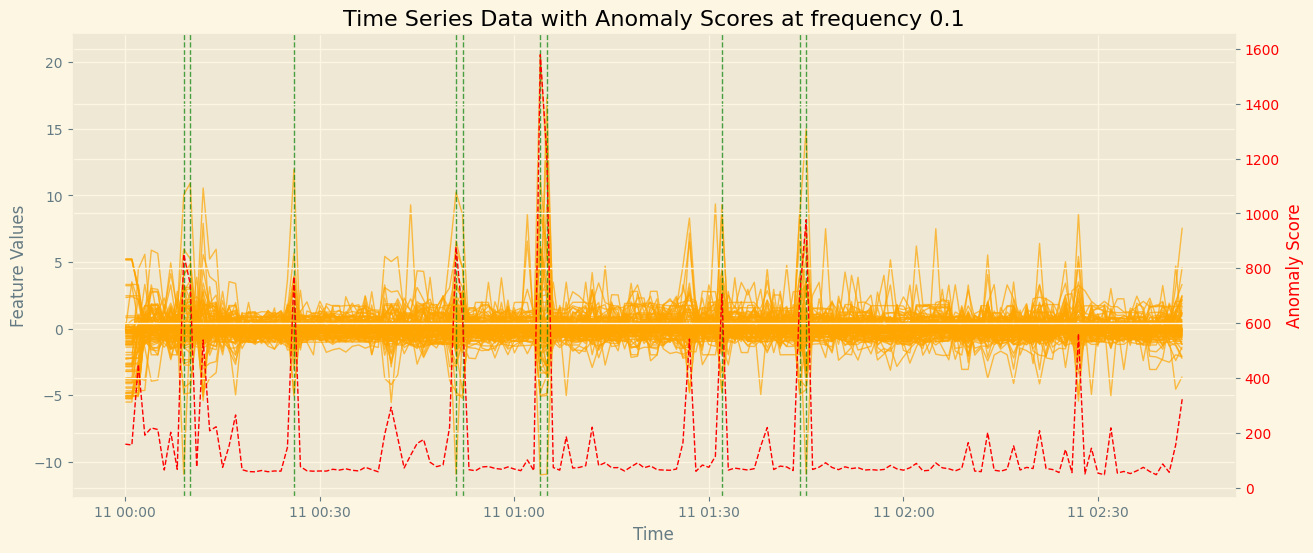

Top 10 Anomalies:
              timestamp  anomaly_score  \
64  2022-08-11 01:04:00    1578.928178   
65  2022-08-11 01:05:00    1216.257739   
105 2022-08-11 01:45:00     976.765007   
51  2022-08-11 00:51:00     877.817031   
9   2022-08-11 00:09:00     851.235048   
26  2022-08-11 00:26:00     768.743843   
10  2022-08-11 00:10:00     743.431761   
92  2022-08-11 01:32:00     705.293932   
104 2022-08-11 01:44:00     701.712610   
52  2022-08-11 00:52:00     623.083497   

     machine_nameKuka Robot_apparent_power-_Average power  \
64                                           -1.885449      
65                                           -1.181816      
105                                          -1.065886      
51                                           -1.115056      
9                                            -0.820232      
26                                           -1.678108      
10                                           -1.011005      
92                             

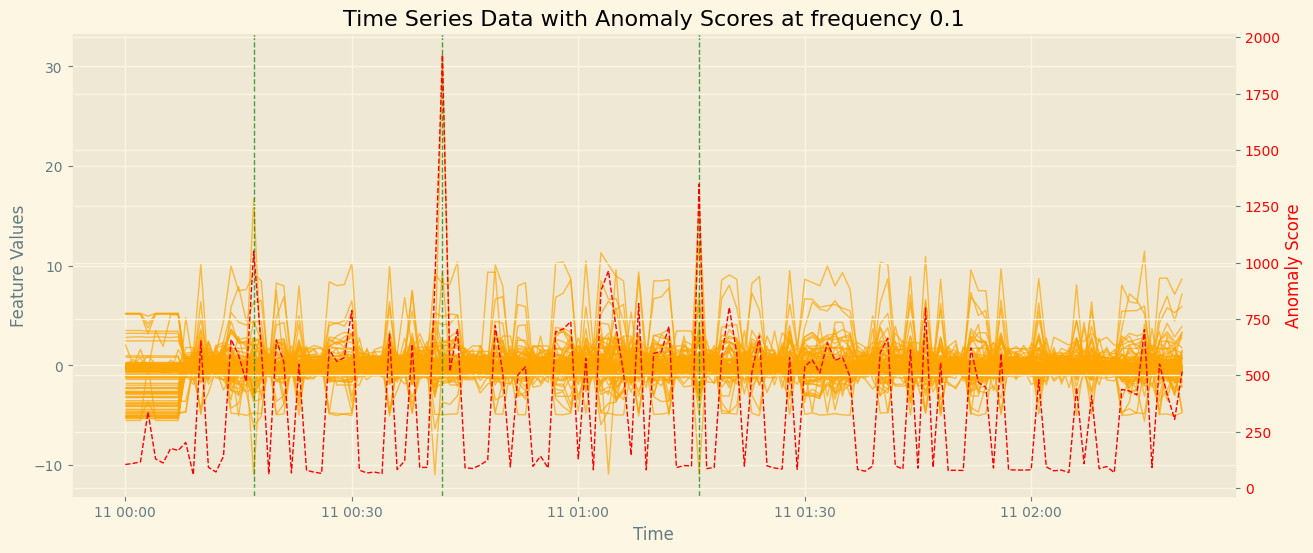

Top 3 Anomalies:
             timestamp  anomaly_score  \
42 2022-08-11 00:42:00    1922.300892   
76 2022-08-11 01:16:00    1348.128981   
17 2022-08-11 00:17:00    1051.279203   

    machine_nameKuka Robot_apparent_power-_Average power  \
42                                          -0.911260      
76                                          -1.338344      
17                                          -0.707436      

    machine_nameKuka Robot_apparent_power-_Variance  \
42                                         0.246879   
76                                         0.201584   
17                                         1.403391   

    machine_nameKuka Robot_current-_Min  \
42                             0.235311   
76                            -0.957586   
17                             0.300387   

    machine_nameKuka Robot_phase_angle-_Average power  \
42                                          -1.270309   
76                                          -1.021451   
17          

In [12]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)